# Information Theoretic Quantum Phase Estimation for Hydrogen with the Iceberg Code

Install `pytket` if it is not available (we use it to create a baseline quantum circuit and to process results):

In [ ]:
# !pip install pytket==1.40.0

We rely on the `algorithm` module for some utility functions:

In [2]:
import numpy as np
from algorithm import generate_ks

The phase estimation algorithm requires to generate a number `n_samples` of circuits using different powers `k` of the controlled unitary Trotterized Hamiltonian, up to the largest power `k_max`.
A list of random angles `beta` is also needed.
Overall, a given pair `(k,beta)` correspond to a single circuit.

In [3]:
# Prepare the samples of (k, beta).
k_max = 16
n_samples = 50  # this will set how many circuits we need to run for the QPE
error_rate = 0.0 # for a noiseless simulation we can set this to 0


def error_rate_func(k: int) -> float:
    q = 1 - (1 - error_rate) ** k
    return q


k_list = generate_ks(k_max, n_samples, error_rate=error_rate_func)
beta_list = (1 - 2 * np.random.random(size=n_samples)).tolist()


## Hamiltonian for the tapered 1-qubit Hydrogen molecule

Coefficients for the controlled unitary Trotterized Hamiltonian $e^{-i \delta t H}$ are defined below

In [4]:
# 1-qubit controlled Hamiltonian trotterization coefficients
CZ = 0.7960489286466914
CX = -0.1809233927385484
CI = -0.3209561440881913
DELTAT = 0.1
# This is the reference energy from a full configuration interaction calculation
FCI_ENERGY = -1.13730605

## The QPE `pytket` circuit as a baseline

Here we define a function that generates the QPE circuit for a given `(k, beta)` pair and encodes it using the [Iceberg Code](https://www.quantinuum.com/blog/protecting-expressive-circuits-with-a-quantum-error-detection-code) with a specified number of syndrome measurement circuits 

In [5]:
from typing import Callable
from pytket.circuit import Circuit


def get_qpe_func_iceberg(syndrome_interval: int) -> Callable[[int, float], Circuit]:

    def qpe_func_iceberg(k: int, beta: float) -> Circuit:
        """Hard-coded QPE circuit function."""
        # Qubit register mapping:
        # [t, 0, 1, b, f0, f1]
        # Bit register mapping:
        # [a0, a1, a2, a3, discard]
        circ = Circuit(6, 5)
        # === FT plus state preparation ===
        circ.H(0)
        circ.CX(0, 4)
        circ.add_barrier(circ.qubits)
        circ.CX(0, 1)
        circ.add_barrier(circ.qubits)
        circ.CX(0, 4)
        circ.add_barrier(circ.qubits)
        circ.H(0)
        circ.H(1)
        circ.H(2)
        circ.Measure(4, 0)
        circ.CX(2, 5)
        circ.add_barrier(circ.qubits)
        circ.CX(2, 3)
        circ.add_barrier(circ.qubits)
        circ.CX(2, 5)
        circ.Measure(5, 1)
        circ.add_classicalexpbox_bit(
            circ.bits[0] | circ.bits[1],
            [circ.bits[4]],
        )
        circ.add_barrier(circ.qubits)
        # === Logical operations ===
        # HF state preparation.
        circ.X(0)
        circ.X(2)
        # ctrl-U^{k} and Rz(beta) operations.
        for ii in range(k):
            circ.ZZPhase(CZ*DELTAT, 2, 3)
            circ.ZZPhase(-CZ*DELTAT, 1, 2)
            circ.XXPhase(CX*DELTAT, 0, 2)
            circ.YYPhase(CX*DELTAT, 0, 2)
            if ii + 1 >= k:
                break
            if (ii + 1) % syndrome_interval == 0:
                circ.add_barrier(circ.qubits)
                circ.Reset(4)
                circ.Reset(5)
                circ.H(5)
                circ.CX(5, 0)
                circ.add_barrier(circ.qubits)
                circ.CX(0, 4)
                circ.add_barrier(circ.qubits)
                circ.CX(1, 4)
                circ.add_barrier(circ.qubits)
                circ.CX(5, 1)
                circ.add_barrier(circ.qubits)
                circ.CX(5, 2)
                circ.add_barrier(circ.qubits)
                circ.CX(2, 4)
                circ.add_barrier(circ.qubits)
                circ.CX(3, 4)
                circ.add_barrier(circ.qubits)
                circ.CX(5, 3)
                circ.add_barrier(circ.qubits)
                circ.Measure(4, 0)
                circ.H(5)
                circ.Measure(5, 1)
                circ.add_classicalexpbox_bit(
                    circ.bits[0] | circ.bits[1] | circ.bits[4],
                    [circ.bits[4]],
                )
                circ.add_barrier(circ.qubits)
        circ.add_barrier(circ.qubits)
        circ.ZZPhase(-CI*DELTAT*k + beta, 1, 3)
        # === FT measurements ===
        circ.add_barrier(circ.qubits)
        circ.Reset(4)
        circ.Reset(5)
        circ.CX(0, 4)
        circ.H(5)
        circ.add_barrier(circ.qubits)
        circ.CX(5, 4)
        circ.add_barrier(circ.qubits)
        circ.CX(1, 4)
        circ.add_barrier(circ.qubits)
        circ.CX(2, 4)
        circ.add_barrier(circ.qubits)
        circ.CX(5, 4)
        circ.add_barrier(circ.qubits)
        circ.CX(3, 4)
        circ.add_barrier(circ.qubits)
        circ.Measure(4, 0)
        circ.H(5)
        circ.Measure(5, 1)
        circ.add_classicalexpbox_bit(
            circ.bits[0] | circ.bits[1] | circ.bits[4],
            [circ.bits[4]],
        )
        circ.add_barrier(circ.qubits)
        circ.H(0)
        circ.H(1)
        circ.H(2)
        circ.H(3)
        circ.Measure(0, 0)
        circ.Measure(1, 1)
        circ.Measure(2, 2)
        circ.Measure(3, 3)
        return circ
    
    return qpe_func_iceberg

A function to generate circuits for any `(k, beta)` pairs at fixed number of syndrome measurements can now be used

In [6]:
qpe_func_iceberg = get_qpe_func_iceberg(syndrome_interval=1)

circ_temp = qpe_func_iceberg(k=2, beta=-0.1)

/tmp/ipykernel_37144/3274549630.py:32: DeprecationWarning: The add_classicalexpbox_bit method is deprecated. Please use Circuit::add_clexpr() instead.
  circ.add_classicalexpbox_bit(
/tmp/ipykernel_37144/3274549630.py:73: DeprecationWarning: The add_classicalexpbox_bit method is deprecated. Please use Circuit::add_clexpr() instead.
  circ.add_classicalexpbox_bit(
/tmp/ipykernel_37144/3274549630.py:100: DeprecationWarning: The add_classicalexpbox_bit method is deprecated. Please use Circuit::add_clexpr() instead.
  circ.add_classicalexpbox_bit(


We can display the circuit in this notebook using the `render_circuit_jupyter` function

In [7]:
from pytket.circuit.display import render_circuit_jupyter as draw

draw(circ_temp)


`pytket` allows users to access the unitary corresponding to a circuit or the statevector (if there are no measurements)

## CUDA-Q Circuits

Now we define `cuda-q` kernels for each sub-routine of the QPE circuit above.

In [8]:
# This is needed to debug `CUDA-Q` calls:
# import os

# os.environ["CUDAQ_LOG_LEVEL"] = "info"
# os.environ["CUDAQ_LOG_LEVEL"] = "trace"

In [9]:
import cudaq

The kernels below are `pure device` kernels and take a quantum register as input, together with other parameters as needed.

### Fault-tolerant state preparation for $|+\rangle$

We comment out any mid-circuit measurements for the time being, to simplify the evaluation of the kernels. For an example on using them see the notebook [qpe_cudaq_iceberg_discard.ipynb](./qpe_cudaq_iceberg_discard.ipynb)

In [10]:
# Fault-tolerant Plus state preparation
@cudaq.kernel
def FTstatePrep(q: cudaq.qview):
    # Qubit register mapping:
    # ic: [t, 0, 1, b, f0, f1]
    #  q: [0, 1, 2, 3, 4, 5]
    h(q[0])
    x.ctrl(q[0], q[4])
    # barrier()
    x.ctrl(q[0], q[1])
    # barrier()
    x.ctrl(q[0], q[4])
    # barrier()
    h(q[0])
    h(q[1])
    h(q[2])
    # bit0 = mz(q[4])
    x.ctrl(q[2], q[5])
    # barrier()
    x.ctrl(q[2], q[3])
    # barrier()
    x.ctrl(q[2], q[5])
    # bit1 = mz(q[5])
    # return (bit0 or bit1)

### Hartree-Fock initial state preparation in the Iceberg Code logical qubits

In [11]:
# logical hartree-fock state preparation
@cudaq.kernel
def HFstatePrep(q: cudaq.qview):
    x(q[0])
    x(q[2])

### Syndrome measurement circuit

In [12]:
# Syndrome measurement circuit
@cudaq.kernel
def syndromeMeasurement(q: cudaq.qview):
    reset(q[4])
    reset(q[5])
    h(q[5])
    x.ctrl(q[5], q[0])
    # barrier()
    x.ctrl(q[0], q[4])
    # barrier()
    x.ctrl(q[1], q[4])
    # barrier()
    x.ctrl(q[5], q[1])
    # barrier()
    x.ctrl(q[5], q[2])
    # barrier()
    x.ctrl(q[2], q[4])
    # barrier()
    x.ctrl(q[3], q[4])
    # barrier()
    x.ctrl(q[5], q[3])
    # barrier()
    # bit0 = mz(q[4])
    h(q[5])
    # bit1 = mz(q[5])
    # return (bit0 or bit1)

### Fault-tolerant measurement circuit

In [13]:
# Fault-tolerant measurements
@cudaq.kernel
def FTmeasurement(q: cudaq.qview):
    reset(q[4])
    reset(q[5])
    x.ctrl(q[0], q[4])
    h(q[5])
    # barrier()
    x.ctrl(q[5], q[4])
    # barrier()
    x.ctrl(q[1], q[4])
    # barrier()
    x.ctrl(q[2], q[4])
    # barrier()
    x.ctrl(q[5], q[4])
    # barrier()
    x.ctrl(q[3], q[4])
    # barrier()
    # bit0 = mz(q[4])
    h(q[5])
    # bit1 = mz(q[5])
    # return (bit0 or bit1)

### Controlled-unitary circuit

We use the `exp_pauli` object to create unitaries that are exponentials of Pauli strings. 
The following kernel implements the controlled unitary raised to the `k` power, and it includes syndrome measurements.
This shows how to combine two `cuda-q` kernels to create more complicated quantum workflows.

In [14]:
from math import pi

coefficients = np.array(
    [
        -pi / 2 * c
        for c in [CZ * DELTAT, -CZ * DELTAT, CX * DELTAT, CX * DELTAT, -CI * DELTAT]
    ],
    dtype=np.float64,
)
# control-U^{k} and Rz(beta) operations
@cudaq.kernel
def ctrlU(q: cudaq.qview, k: int, rescaled_beta: float, coeffs: list[float], syndrome_interval: int):
    for i in range(k):
        exp_pauli(coeffs[0], q, "IIZZII")  # this is the pauli exponential e^{i c Z2Z3}
        exp_pauli(coeffs[1], q, "IZZIII")  # this is the pauli exponential e^{i c Z1Z2}
        exp_pauli(coeffs[2], q, "XIXIII")  # this is the pauli exponential e^{i c X0X2}
        exp_pauli(coeffs[3], q, "YIYIII")  # this is the pauli exponential e^{i c Y0Y2}
        if i + 1 >= k:  # no syndrome measurement in the last iteration
            break
        if (i + 1) % syndrome_interval == 0:
            syndromeMeasurement(q)
    exp_pauli(coeffs[4]*k + rescaled_beta, q, "IZIZII")  # this is the pauli exponential e^{i c Z1Z3}

### Putting everything together

Using the sub-routines given by the kernels above, we can build the full QPE circuit for any given value of `(k, beta)` and number of syndrome measurements.

We add the measurement of two ancilla qubits in the `Z` basis to partially detect some errors.

In [15]:
@cudaq.kernel(verbose=False)
def qpe_iceberg(k: int, rescaled_beta: float, syndrome_interval: int):
    q = cudaq.qvector(6)
    # state preparation
    FTstatePrep(q)
    # HF state preparation
    HFstatePrep(q)
    # ctrl-U with syndrome
    ctrlU(q, k, rescaled_beta, coefficients, syndrome_interval)
    # FT measurements
    FTmeasurement(q)
    # measure in X basis
    h(q)
    mz(q)



## Create and sample shots from the circuits

We can now create the circuits and use the `cudaq.sample` primitive to take shots from those circuits.

First we set the target of `cuda-q` to a simulation backend:

In [16]:
# CPU
cudaq.set_target('qpp-cpu')


Now we can test a single circuit

In [17]:
k = 3
beta = -0.1
syndrome_interval = 1
counts = cudaq.sample(qpe_iceberg, k, beta, syndrome_interval, shots_count=10)
counts.dump()

{ 000000:1 001110:1 010100:1 010101:1 010110:1 101010:1 110001:1 111100:1 111101:1 111110:1 }


We are now ready to execute all the circuits and collect their results. We take 1 shot per circuit

In [18]:
# Execute the QPE circuits.
results = []
for k,b in zip(k_list,beta_list):
    rb = -pi/2*b  # rescaling needed for beta
    results.append(cudaq.sample(qpe_iceberg, k, rb, 1, shots_count=1))

We write a helper function to translate the CUDA-Q `SampleResult` into the pytket `BackendResult`. This function will also discard a count if it detects an error in the parity of the measured encoded qubits.

In [19]:
from pytket import Bit
from pytket.backends.backendresult import BackendResult
from pytket.utils.outcomearray import OutcomeArray
from typing import Counter


def get_decoded_result(result: cudaq.SampleResult) -> BackendResult:
    logical_counts = Counter()
    
    for bitstring, counts in result.items():
        if (
            int(bitstring[0])
            + int(bitstring[1])
            + int(bitstring[2])
            + int(bitstring[3])
        ) % 2 != 0:
            print("Parity Error detected! Discard")
            continue
        logical_readout = tuple(
            [(1 - (-1) ** (int(bitstring[0]) + int(bitstring[1]))) // 2]
        )
        logical_counts[OutcomeArray.from_readouts([logical_readout])] += counts

    logical_result = BackendResult(
        counts=logical_counts,
        c_bits=[Bit(0)],
    )
    return logical_result

In [20]:
# Interpret the encoded results back in the logical space.
logical_results = [get_decoded_result(r) for r in results]


In [21]:
logical_results

[BackendResult(q_bits={},c_bits={c[0]: 0},counts=Counter({OutcomeArray([[0]], dtype=uint8): 1}),shots=None,state=None,unitary=None,density_matrix=None),
 BackendResult(q_bits={},c_bits={c[0]: 0},counts=Counter({OutcomeArray([[128]], dtype=uint8): 1}),shots=None,state=None,unitary=None,density_matrix=None),
 BackendResult(q_bits={},c_bits={c[0]: 0},counts=Counter({OutcomeArray([[128]], dtype=uint8): 1}),shots=None,state=None,unitary=None,density_matrix=None),
 BackendResult(q_bits={},c_bits={c[0]: 0},counts=Counter({OutcomeArray([[128]], dtype=uint8): 1}),shots=None,state=None,unitary=None,density_matrix=None),
 BackendResult(q_bits={},c_bits={c[0]: 0},counts=Counter({OutcomeArray([[128]], dtype=uint8): 1}),shots=None,state=None,unitary=None,density_matrix=None),
 BackendResult(q_bits={},c_bits={c[0]: 0},counts=Counter({OutcomeArray([[128]], dtype=uint8): 1}),shots=None,state=None,unitary=None,density_matrix=None),
 BackendResult(q_bits={},c_bits={c[0]: 0},counts=Counter({OutcomeArray([

## Post-process the results using utility functions performing the Bayesian Maximum Likelihood computation

In [22]:
from algorithm import get_mu_and_sigma, bayesian_update


# Prepare the uniform prior distribution.
n_grid_points = 2**14
phi = np.linspace(-1, 1, n_grid_points + 1)[:-1]
prior = np.ones_like(phi)

posterior = bayesian_update(
    phi,
    prior,
    k_list,
    beta_list,
    logical_results,
    error_rate=error_rate_func,
)

In [23]:
mu, sigma = get_mu_and_sigma(posterior, phi=phi)
mu_energy = -mu / DELTAT
sigma_energy = sigma / DELTAT
print(f"Energy estimate = {mu_energy:11.5f} Ha")
print(f"Energy sigma    = {sigma_energy:11.5f} Ha")
print(f"FCI energy      = {FCI_ENERGY:11.5f} Ha")

Energy estimate =    -1.15078 Ha
Energy sigma    =     0.05391 Ha
FCI energy      =    -1.13731 Ha


### Plot probability distribution

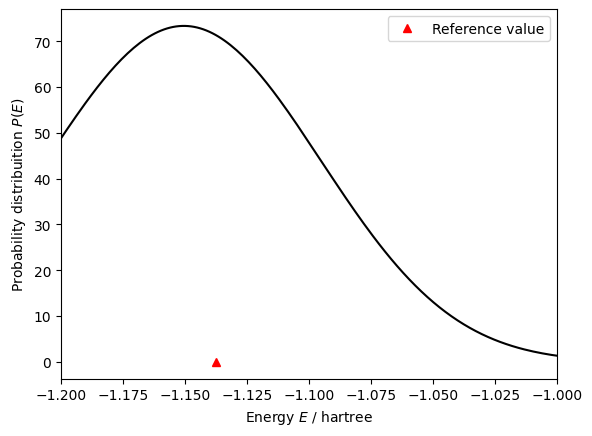

In [24]:
import matplotlib.pyplot as plt

x_energy = -phi / DELTAT
plt.plot(x_energy, posterior, "k-")
plt.xlim([-1.2,-1.0])
plt.plot(FCI_ENERGY, 0, "r^", label="Reference value")
plt.xlabel(r"Energy $E$ / hartree")
plt.ylabel(r"Probability distribuition $P(E)$")
plt.legend()

## Noisy Simulations

We can repeat the simulation above after introducing a noise model for the gate operations. We can use some functions from [this example](https://nvidia.github.io/cuda-quantum/latest/applications/python/logical_aim_sqale.html#Running-a-CUDA-Q-noisy-simulation) in the `cuda-q` documentation

In [25]:
def get_device_noise(
    depolar_prob_1q: float,
    depolar_prob_2q: float,
    *,
    readout_error_prob: float | None = None,
    custom_gates: list[str] | None = None,
) -> cudaq.mlir._mlir_libs._quakeDialects.cudaq_runtime.NoiseModel:
    noise = cudaq.NoiseModel()
    depolar_noise = cudaq.DepolarizationChannel(depolar_prob_1q)

    noisy_ops = ["z", "s", "x", "h", "rx", "rz"]
    for op in noisy_ops:
        noise.add_all_qubit_channel(op, depolar_noise)

    if custom_gates:
        custom_depolar_channel = cudaq.DepolarizationChannel(depolar_prob_1q)
        for op in custom_gates:
            noise.add_all_qubit_channel(op, custom_depolar_channel)

    # Two qubit depolarization error
    p_0 = 1 - depolar_prob_2q
    p_1 = np.sqrt((1 - p_0**2) / 3)

    k0 = np.array(
        [[p_0, 0.0, 0.0, 0.0], [0.0, p_0, 0.0, 0.0], [0.0, 0.0, p_0, 0.0], [0.0, 0.0, 0.0, p_0]],
        dtype=np.complex128,
    )
    k1 = np.array(
        [[0.0, 0.0, p_1, 0.0], [0.0, 0.0, 0.0, p_1], [p_1, 0.0, 0.0, 0.0], [0.0, p_1, 0.0, 0.0]],
        dtype=np.complex128,
    )
    k2 = np.array(
        [
            [0.0, 0.0, -1j * p_1, 0.0],
            [0.0, 0.0, 0.0, -1j * p_1],
            [1j * p_1, 0.0, 0.0, 0.0],
            [0.0, 1j * p_1, 0.0, 0.0],
        ],
        dtype=np.complex128,
    )
    k3 = np.array(
        [[p_1, 0.0, 0.0, 0.0], [0.0, p_1, 0.0, 0.0], [0.0, 0.0, -p_1, 0.0], [0.0, 0.0, 0.0, -p_1]],
        dtype=np.complex128,
    )
    kraus_channel = cudaq.KrausChannel([k0, k1, k2, k3])

    noise.add_all_qubit_channel("cz", kraus_channel)
    noise.add_all_qubit_channel("cx", kraus_channel)

    if readout_error_prob is not None:
        # Readout error modeled with a Bit flip channel on identity before measurement
        bit_flip = cudaq.BitFlipChannel(readout_error_prob)
        noise.add_all_qubit_channel("mz", bit_flip)
    return noise

The next cell builds a custom noise model that can be used by `cuda-q`

In [26]:
# Example parameters that can model execution on hardware at the high, simulation, level:
# Take single-qubit gate depolarization rate: ~0.01% or better (fidelity ≥99.99%)
# Take two-qubit gate depolarization rate: ~0.1% (fidelity ~99.9%)
cudaq_noise_model = get_device_noise(0.0001, 0.001, readout_error_prob=0.001)

A simulator that can use the noise model is the `density-matrix-cpu` target

In [27]:
# this is needed for noisy simulations
cudaq.reset_target()
cudaq.set_target("density-matrix-cpu")

Since we have a noisy backend, we can improve our information theoretic QPE algorithm by telling our likelihood that our gates are noisy.

In [ ]:
# Prepare the samples of (k, beta).
k_max = 16
n_samples = 50  # this will set how many circuits we need to run for the QPE
error_rate = 0.002  # this is for the custom noise model above: we consider a factor of 2 because we have 2 TQ gates in each controlled-U step


def error_rate_func(k: int) -> float:
    q = 1 - (1 - error_rate) ** k
    return q


k_list = generate_ks(k_max, n_samples, error_rate=error_rate_func)
beta_list = (1 - 2 * np.random.random(size=n_samples)).tolist()

In [29]:
# Execute the QPE circuits.
results = []
for k,b in zip(k_list,beta_list):
    rb = -pi/2*b  # rescaling needed for beta
    results.append(cudaq.sample(qpe_iceberg, k, rb, 4, shots_count=1, noise_model=cudaq_noise_model))

In [30]:
# Interpret the encoded results back in the logical space.
logical_results = [get_decoded_result(r) for r in results]

Parity Error detected! Discard
Parity Error detected! Discard
Parity Error detected! Discard


In [31]:
# Prepare the uniform prior distribution.
n_grid_points = 2**14
phi = np.linspace(-1, 1, n_grid_points + 1)[:-1]
prior = np.ones_like(phi)

posterior = bayesian_update(
    phi,
    prior,
    k_list,
    beta_list,
    logical_results,
    error_rate=error_rate_func,
)

In [32]:
mu, sigma = get_mu_and_sigma(posterior, phi=phi)
mu_energy = -mu / DELTAT
sigma_energy = sigma / DELTAT
print(f"Energy estimate = {mu_energy:11.5f} Ha")
print(f"Energy sigma    = {sigma_energy:11.5f} Ha")
print(f"FCI energy      = {FCI_ENERGY:11.5f} Ha")

Energy estimate =    -1.12191 Ha
Energy sigma    =     0.05404 Ha
FCI energy      =    -1.13731 Ha


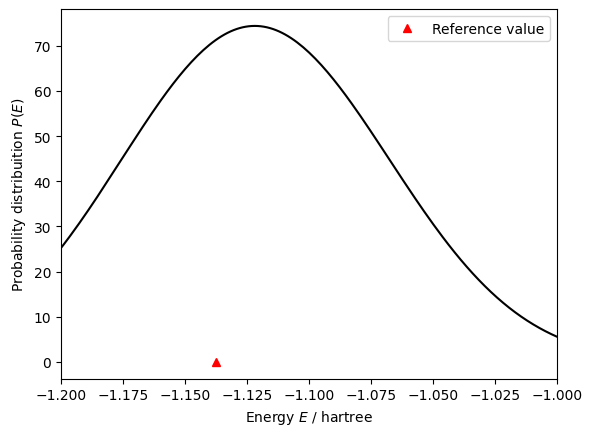

In [33]:
import matplotlib.pyplot as plt

x_energy = -phi / DELTAT
plt.plot(x_energy, posterior, "k-")
plt.xlim([-1.2,-1.0])
plt.plot(FCI_ENERGY, 0, "r^", label="Reference value")
plt.xlabel(r"Energy $E$ / hartree")
plt.ylabel(r"Probability distribuition $P(E)$")
plt.legend()

## Run on Quantinuum Systems

Documentation on how to access Quantinuum Systems via `cuda-q` is provided in the Quantinuum documentation [page](https://docs.quantinuum.com/systems/trainings/getting_started/getting_started_index.html)

In order to use Quantinuum systems, you need to have an account and store your credentials as discussed in the documentation page.

In [41]:
# this is needed for Quantinuum systems
cudaq.reset_target()
machine = "H1-1SC"  # or H1-1SC for the syntax checker or H1-1E for the emulator
are_we_emulating_in_cudaq = False
cudaq.set_target("quantinuum", machine=machine, emulate=are_we_emulating_in_cudaq)

Setting `emulate=True` in the cell above will not run any calls to the Quantinuum API, but it will test the compilation of the kernels.
With `emulate=False` (which is the default value), the API will be queried and the jobs will be submitted to the selected `machine`.
Jobs submitted to the machine will apper in the quantum computing platform [Quantinuum Nexus](https://docs.quantinuum.com/nexus/index.html).

In [ ]:
# Prepare the samples of (k, beta).
k_max = 16
n_samples = 10  # this will set how many circuits we need to run for the QPE
error_rate = 0.002  # this is for the custom noise model on H1-1: we consider a factor of 2 because we have 2 TQ gates in each controlled-U step


def error_rate_func(k: int) -> float:
    q = 1 - (1 - error_rate) ** k
    return q


k_list = generate_ks(k_max, n_samples, error_rate=error_rate_func)
beta_list = (1 - 2 * np.random.random(size=n_samples)).tolist()

When running on remote QPU, we can use the `cudaq.sample_async` and save the result of the job ID on a file for later retrieval.

In [43]:
# Execute the QPE circuits and save output for future retireval
# if running on Quantinuum Systems with sample_async.
import os
import json

results_dir = f"results_{machine}_{k_max}_{n_samples}"
os.makedirs(results_dir, exist_ok=True)

results = []
for k, b in zip(k_list, beta_list):
    rb = -pi / 2 * b  # rescaling needed for beta
    if are_we_emulating_in_cudaq:
        # emulation runs immediately
        tmp_result = cudaq.sample(qpe_iceberg, k, rb, k_max, shots_count=1)
        results.append(tmp_result)
    else:
        # this runs asyncronously and submits to the Quantinuum API
        tmp_result = cudaq.sample_async(qpe_iceberg, k, rb, k_max, shots_count=1)
        with open(f"{results_dir}/job_{k}_{b}.json", "w") as file_io:
            json.dump(str(tmp_result), file_io)

We get the job info from the files and get the results from the cloud QPU once they are ready. In this case we are running only the Quantinuum Syntax Checker, so we do not expect the returned counts to be from actual shots of the circuit.

In [44]:
import os
import json

if not are_we_emulating_in_cudaq:
    results = []
    for file in os.listdir(results_dir):
        with open(f"{results_dir}/{file}", "r") as file_io:
            job_data = json.load(file_io)
        tmp_results = cudaq.AsyncSampleResult(str(job_data))
        counts = tmp_results.get()
        results.append(counts)

Here is an example of the result from Quantinuum Systems `H1-1SC`

In [45]:
results[0].dump()

{ 
  __global__ : { 000000:1 }
   r00000 : { 0:1 }
   r00001 : { 0:1 }
   r00002 : { 0:1 }
   r00003 : { 0:1 }
   r00004 : { 0:1 }
   r00005 : { 0:1 }
}


In [46]:
type(results[0])

cudaq.mlir._mlir_libs._quakeDialects.cudaq_runtime.SampleResult

The results are of type `cudaq.SampleResult` as we saw in the case of a simulation backend. This means the workflow to process the results to obtain the final answer will not change even though we are using the Quantinuum Systems.

For results obtained from the `H1-1E` emulator we can get load the results already saved on disk and make a plot

In [47]:
import numpy as np
import json

# Read k_list and beta_list from text files
k_list = np.loadtxt("results_H1-1E/k_list.txt", dtype=int).tolist()
beta_list = np.loadtxt("results_H1-1E/beta_list.txt", dtype=float).tolist()

# Load logical results from JSON files
logical_results = []
for i in range(len(k_list)):
    with open(f"results_H1-1E/logical_result_{i}.json", "r") as f:
        result_dict = json.load(f)
        logical_results.append(BackendResult.from_dict(result_dict))

print(k_list)
print(beta_list)
print(logical_results[0])

[15, 7, 9, 5, 15, 1, 5, 7, 4, 13, 12, 9, 9, 13, 6, 5, 15, 2, 8, 14, 12, 12, 1, 11, 5, 3, 4, 10, 16, 11, 11, 10, 4, 16, 6, 13, 6, 16, 1, 11, 14, 15, 6, 16, 2, 14, 13, 7, 12, 11]
[0.27017512, -0.47394802, 0.0466498, -0.50235102, -0.8672703, 0.44692812, 0.32392869, -0.001313, 0.31648886, -0.65808325, 0.88069354, 0.46200438, -0.54192628, 0.90491895, -0.87763258, 0.99472779, 0.66869691, 0.5255515, -0.73701811, 0.12615369, 0.45811549, -0.22744194, 0.26105682, -0.1323189, -0.7998807, -0.03014, -0.70235605, -0.94922763, -0.09694152, 0.44925274, 0.20773296, 0.43156246, 0.3038661, -0.60392304, -0.12735312, 0.33493999, 0.41248766, 0.09322811, 0.39017891, -0.5706066, 0.61596944, -0.99933448, 0.13725022, 0.53325828, -0.17347777, -0.80427508, 0.62151118, 0.92580193, 0.57938717, -0.3682388]
BackendResult(q_bits={},c_bits={c[0]: 0},counts=Counter(),shots=None,state=None,unitary=None,density_matrix=None)


In [48]:
from algorithm import get_mu_and_sigma, bayesian_update

# Prepare the uniform prior distribution.
n_grid_points = 2**14
phi = np.linspace(-1, 1, n_grid_points + 1)[:-1]
prior = np.ones_like(phi)

posterior = bayesian_update(
    phi,
    prior,
    k_list,
    beta_list,
    logical_results,
    error_rate=error_rate_func,
)

mu, sigma = get_mu_and_sigma(posterior, phi=phi)
mu_energy = -mu / DELTAT
sigma_energy = sigma / DELTAT
print(f"Energy estimate = {mu_energy:11.5f} Ha")
print(f"Energy sigma    = {sigma_energy:11.5f} Ha")
print(f"FCI energy      = {FCI_ENERGY:11.5f} Ha")

Energy estimate =    -1.19576 Ha
Energy sigma    =     0.05067 Ha
FCI energy      =    -1.13731 Ha


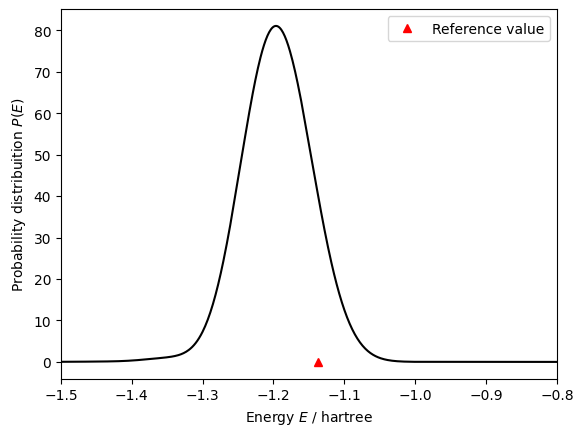

In [49]:
import matplotlib.pyplot as plt

x_energy = -phi / DELTAT
plt.plot(x_energy, posterior, "k-")
plt.xlim(-1.5, -0.8)
plt.plot(FCI_ENERGY, 0, "r^", label="Reference value")
plt.xlabel(r"Energy $E$ / hartree")
plt.ylabel(r"Probability distribuition $P(E)$")
plt.legend()